In [1]:
from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sbn
from typing import Any, List, Type
from mpl_toolkits.mplot3d import Axes3D
from stats import *
import matplotlib
from datetime import datetime

In [2]:
#df=pd.read_csv("ActonMay4.csv")
df = pd.read_csv('ActonMay4.csv', infer_datetime_format=True, parse_dates=[4, 5])

In [3]:
prediction_start = df["measurement_end_utc"].iloc[-1] - np.timedelta64(2, 'D')

In [4]:
train_data=df[df["measurement_end_utc"]<=prediction_start]
test_data=df[df["measurement_end_utc"]>prediction_start]

In [5]:
detectors=df["detector_id"].drop_duplicates()
detector_sample=detectors.sample(n=4, random_state=1)
detector_sample=detector_sample.to_numpy()


In [6]:
detector_sample

array(['N27/010d1', 'N25/263a1', 'N25/215g2', 'N27/227d1'], dtype=object)

In [7]:
MA(train_data,'N25/011d2', 5)

181.425

In [8]:
MALD(train_data,"N24/012a1", 4)

0.005466801125205668

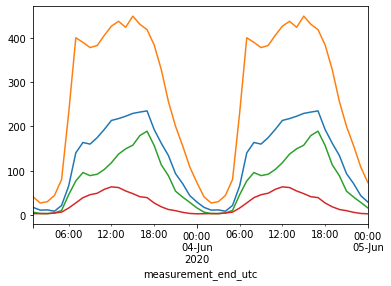

In [9]:
y=forecast(train_data, detector_sample, 5, 2, display=True)

In [17]:
y

,detector_id,lon,lat,measurement_start_utc,measurement_end_utc,n_vehicles_in_interval
0,N27/010d1,-0.294455,51.51683,2020-06-02 23:00:00,2020-06-03 00:00:00,19.724447
1,N27/010d1,-0.294455,51.51683,2020-06-03 00:00:00,2020-06-03 01:00:00,11.553111
2,N27/010d1,-0.294455,51.51683,2020-06-03 01:00:00,2020-06-03 02:00:00,11.063787
3,N27/010d1,-0.294455,51.51683,2020-06-03 02:00:00,2020-06-03 03:00:00,10.012239
4,N27/010d1,-0.294455,51.51683,2020-06-03 03:00:00,2020-06-03 04:00:00,23.959306
...,...,...,...,...,...,...
43,N27/227d1,-0.305321,51.51043,2020-06-04 18:00:00,2020-06-04 19:00:00,20.389976
44,N27/227d1,-0.305321,51.51043,2020-06-04 19:00:00,2020-06-04 20:00:00,15.416884
45,N27/227d1,-0.305321,51.51043,2020-06-04 20:00:00,2020-06-04 21:00:00,10.573828
46,N27/227d1,-0.305321,51.51043,2020-06-04 21:00:00,2020-06-04 22:00:00,7.487093


[0.11680669 0.18362955 0.1007408  0.29363594 0.34367528 0.86930552
 1.50530844 2.28389908 2.88681121 3.03897499 3.57229178 3.91392012
 3.93688469 3.64237715 3.08619256 2.57345642 2.4730168  1.66592515
 1.2523996  0.72315197 0.54323136 0.370181   0.26043941 0.1671    ]


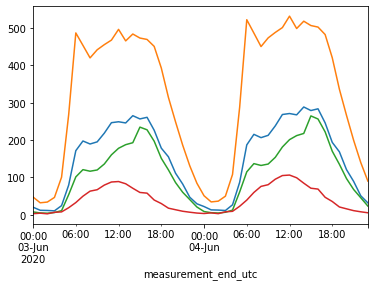

In [14]:
y=holt_winters(train_data, detector_sample, 20, 2, display=True, alpha=0.05, beta=0.05, gamma=0.2)

In [15]:
sd=[]
for detector in detector_sample:
    sd.append(test_data[test_data['detector_id']==detector])
sample_test_data=pd.concat(sd)

In [16]:
sample_test_data

,Unnamed: 0,detector_id,lon,lat,measurement_start_utc,measurement_end_utc,n_vehicles_in_interval
86623,86623,N27/010d1,-0.294455,51.51683,2020-06-03 00:00:00,2020-06-03 01:00:00,16
86624,86624,N27/010d1,-0.294455,51.51683,2020-06-03 01:00:00,2020-06-03 02:00:00,13
86625,86625,N27/010d1,-0.294455,51.51683,2020-06-03 02:00:00,2020-06-03 03:00:00,11
86626,86626,N27/010d1,-0.294455,51.51683,2020-06-03 03:00:00,2020-06-03 04:00:00,7
86627,86627,N27/010d1,-0.294455,51.51683,2020-06-03 04:00:00,2020-06-03 05:00:00,16
...,...,...,...,...,...,...,...
119912,119912,N27/227d1,-0.305321,51.51043,2020-06-04 19:00:00,2020-06-04 20:00:00,17
119913,119913,N27/227d1,-0.305321,51.51043,2020-06-04 20:00:00,2020-06-04 21:00:00,4
119914,119914,N27/227d1,-0.305321,51.51043,2020-06-04 21:00:00,2020-06-04 22:00:00,5
119915,119915,N27/227d1,-0.305321,51.51043,2020-06-04 22:00:00,2020-06-04 23:00:00,3


In [18]:
y["count"]=sample_test_data["n_vehicles_in_interval"].to_numpy()

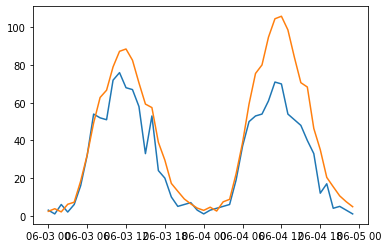

In [20]:
y[y["detector_id"]=="N27/010d1"]
plt.plot(y[y["detector_id"]=="N27/010d1"]["measurement_end_utc"], y[y["detector_id"]=="N27/227d1"]["count"])
plt.plot(y[y["detector_id"]=="N27/010d1"]["measurement_end_utc"], y[y["detector_id"]=="N27/227d1"]["n_vehicles_in_interval"])

In [16]:
# def dataframe_org(df):
#     df2=df.sort_values(by=['measurement_end_utc'])
#     df2.index=pd.to_datetime(df2['measurement_end_utc'])
#     df2=df2.drop(["Unnamed: 0", "measurement_start_utc", "measurement_end_utc"], axis=1)
#     return df2
    
    

# def MA(df, detector, past_days):
#     one_D=df[df["detector_id"]==detector]
#     return(one_D.tail(n=24*past_days)['n_vehicles_in_interval'].mean())

# def MALD(df, detector, hour):
#     one_D=df[df["detector_id"]==detector]
#     hour=f'{hour:02}'
#     beta=(one_D.loc[one_D.index.strftime("%H") == hour]['n_vehicles_in_interval'].sum())/(one_D['n_vehicles_in_interval'].sum())
#     return beta

# def MAGD(df, hour):
#     hour=f'{hour:02}'
#     beta=(df.loc[df.index.strftime("%H") == hour]['n_vehicles_in_interval'].sum())/(df['n_vehicles_in_interval'].sum())
#     return beta

# def forecast(df, detectors, days_in_past, days_in_future, display=False):
#     framelist=[]
#     for detector in detectors:
#         meanV=MA(df, detector, days_in_past)
#         pred=[]
#         index=[]
#         for i in range(1, 24*days_in_future +1):
#             time=df.index[-1]+ np.timedelta64(i, 'h')
#             beta=MALD(df, detector, time.hour)
#             index.append(time)
#             pred.append(beta*24*meanV)

#         df2 = pd.DataFrame({"measurement_end_utc":index, "n_vehicles_in_interval": pred})
#         df2["detector_id"]=detector
#         df2["lon"] = df[df["detector_id"]==detector]["lon"][0]
#         df2["lat"] = df[df["detector_id"]==detector]["lat"][0]
        
#         framelist.append(df2)
#     DF=pd.concat(framelist)
#     DF=DF.set_index('measurement_end_utc')
    
#     if(display):
#         for detector in detectors:
#             DF[DF["detector_id"]==detector]["n_vehicles_in_interval"].plot()
    
#     return DF
        
    

In [12]:
# def holt_winters(df, detectors, days_in_past, days_in_future, alpha=0.1, beta=0.1, gamma=0.1, display=False):
#     framelist=[]
#     for detector in detectors:
#         S=1; T=1; I=np.ones(24);
#         past=df[df["detector_id"]==detector].tail(n=24*days_in_past)
#         for i in range(0, len(past)):
#             h=i%24
#             c = past["n_vehicles_in_interval"][i]
#             Snew = (alpha*(c/I[h])) + (1-alpha)*(S + T)
#             T = beta*(Snew - S) + (1-beta)*T
#             I[h] = gamma*(c/Snew) + (1-gamma)*I[h]
#             S=Snew

#         baseline=[]
#         index = []
#         for j in range(0, days_in_future*24):
#             time=df.index[-1]+ np.timedelta64(j, 'h')
#             h=j%24
#             b=(S + T)*I[h]
#             baseline.append(b)
#             index.append(time)

#             Snew = (alpha*(b/I[h])) + (1-alpha)*(S + T)
#             T = beta*(Snew - S) + (1-beta)*T
#             I[h] = gamma*(b/Snew) + (1-gamma)*I[h]
#             S=Snew

#         df2 = pd.DataFrame({"measurement_end_utc":index, "n_vehicles_in_interval": baseline})
#         df2["detector_id"]=detector
#         df2["lon"] = df[df["detector_id"]==detector]["lon"][0]
#         df2["lat"] = df[df["detector_id"]==detector]["lat"][0]
#         framelist.append(df2)
#     DF=pd.concat(framelist)
#     DF=DF.set_index('measurement_end_utc')
    
#     if(display):
#         for detector in detectors:
#             DF[DF["detector_id"]==detector]["n_vehicles_in_interval"].plot()

#     return DF
        
        
        
    
    

In [12]:
x=holt_winters(df, detector_sample, 20, 3, display=True)


KeyError: 0

In [26]:
y=forecast(df3, detector_sample, 30, 2, display=True)

NameError: name 'df3' is not defined

,n_vehicles_in_interval,detector_id,lon,lat
measurement_end_utc,,,,
2020-06-05 00:00:00,69.025712,N25/011c1,-0.302877,51.489921
2020-06-05 01:00:00,57.888792,N25/011c1,-0.302877,51.489921
2020-06-05 02:00:00,50.756757,N25/011c1,-0.302877,51.489921
2020-06-05 03:00:00,50.972302,N25/011c1,-0.302877,51.489921
2020-06-05 04:00:00,72.529212,N25/011c1,-0.302877,51.489921
...,...,...,...,...
2020-06-06 19:00:00,342.849320,N27/019b1,-0.305804,51.511848
2020-06-06 20:00:00,264.844376,N27/019b1,-0.305804,51.511848
2020-06-06 21:00:00,199.843060,N27/019b1,-0.305804,51.511848


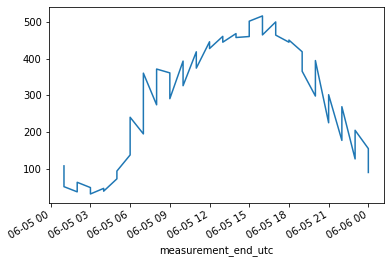

In [272]:
df5[df5["detector_id"]=="N27/299a1"]["n_vehicles_in_interval"].plot()

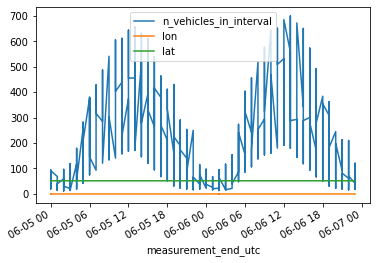

In [492]:
x.plot()

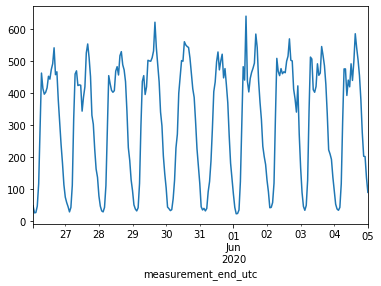

In [413]:
df3[df3["detector_id"]=="N24/012a1"].tail(n=24*10)["n_vehicles_in_interval"].plot()

In [321]:
print(MAGD(df3, 17), MALD(df3, "N24/012a1", 17))

0.06863983542005232 0.07126539555586124


In [260]:
df[df["detector_id"]=="N24/012a1"]["lon"][0]

-0.28800795553729697

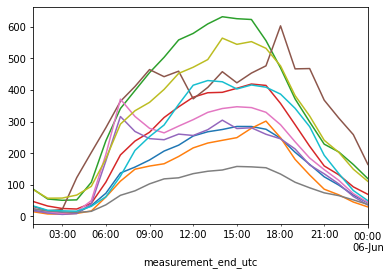

In [322]:
df5=forecast(df3, detector_sample, 1, 1, display=True)

In [1]:
df5

NameError: name 'df5' is not defined

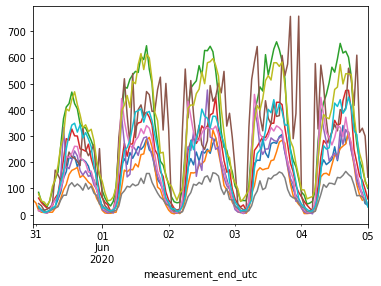

In [503]:
for detector in detector_sample:
            df3[df3["detector_id"]==detector].tail(24*5)["n_vehicles_in_interval"].plot()


In [215]:
df2=one_D.tail(n=24)
for i in range(0, len(df2)-1):
    print(df2["n_vehicles_in_interval"][i], df2["n_vehicles_in_interval"][i+1])

53 38
38 34
34 43
43 117
117 312
312 476
476 476
476 393
393 441
441 420
420 492
492 440
440 500
500 586
586 542
542 504
504 455
455 380
380 277
277 203
203 202
202 136
136 90


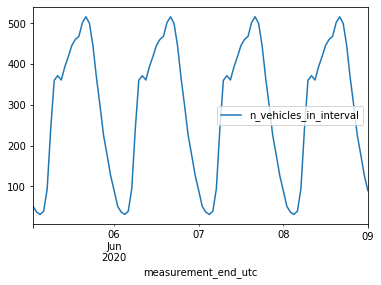

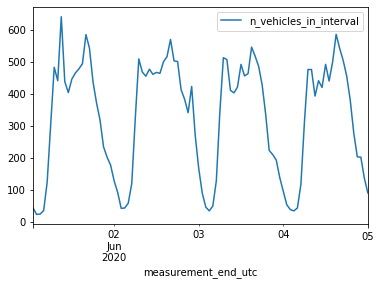

In [203]:
forecast(one_D, 20, 4).plot()
one_D.tail(n=24*4).plot()

In [130]:
def MA(df, past_days):
    return(df.tail(n=24*past_days)['n_vehicles_in_interval'].mean())
    
    

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df2.index, df2['lon'], df2['lat'])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')

TypeError: invalid type promotion

ValueError: view limit minimum -0.05 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [24]:
def HW(df, detectors, days_in_past, days_in_future, alpha=0.1, beta=0.1, gamma=0.1, display=False):
    framelist=[]
    for detector in detectors:
        S=1
        T=1
        I=np.ones(24)
        one_D=df[df["detector_id"]==detector]
        one_D=one_D.sort_values(by=['measurement_end_utc'])
        past=one_D.tail(n=24*days_in_past)
        #print(past)
        for i in range(0, len(past)):
            h=i%24
            c = past["n_vehicles_in_interval"].iloc[i]
            Snew = (alpha*(c/I[h])) + (1-alpha)*(S + T)
            T = beta*(Snew - S) + (1-beta)*T
            I[h] = gamma*(c/Snew) + (1-gamma)*I[h]
            S=Snew

        baseline = []
        endtime = []
        starttime = []
        for j in range(0, days_in_future*24):
            end=df['measurement_end_utc'].to_numpy()[-1] + np.timedelta64(j, 'h')
            start=df['measurement_start_utc'].to_numpy()[-1] + np.timedelta64(j, 'h')
            h=j%24
            b=(S + T)*I[h]
            baseline.append(b)
            endtime.append(end)
            starttime.append(start)

            Snew = (alpha*(b/I[h])) + (1-alpha)*(S + T)
            T = beta*(Snew - S) + (1-beta)*T
            I[h] = gamma*(b/Snew) + (1-gamma)*I[h]
            S=Snew

        df2 = pd.DataFrame({"detector_id" : detector, "lon" : df[df["detector_id"]==detector]["lon"].to_numpy()[0], "lat" : df[df["detector_id"]==detector]["lat"].to_numpy()[0], 'measurement_start_utc': starttime, 'measurement_end_utc':endtime, "n_vehicles_in_interval": baseline})
        framelist.append(df2)
    DF=pd.concat(framelist)
    
    if(display):
            df_plot=DF.set_index('measurement_end_utc')
            for detector in detectors:
                df_plot[df_plot["detector_id"]==detector]["n_vehicles_in_interval"].plot()

    return DF

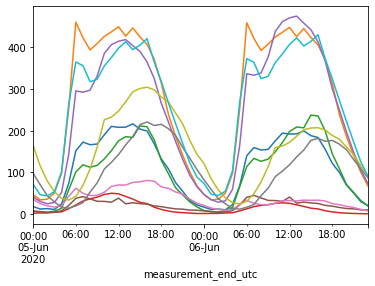

In [28]:
x=HW(df, detector_sample, 30, 2, display=True)

In [21]:
one_D=df[df["detector_id"]=='N27/010d1']
one_D=one_D.sort_values(by=['measurement_end_utc'])
past=one_D.tail(n=24*2)
past["n_vehicles_in_interval"].iloc[0]

16